In [15]:
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go

tickerSymbol = 'SPY'

tickerData = yf.Ticker(tickerSymbol)

tickerDF = tickerData.history(period='1d', start='2024-01-01', end='2024-05-01')

print(tickerDF.head())

                                 Open        High         Low       Close  \
Date                                                                        
2024-01-02 00:00:00-05:00  470.697532  472.202865  469.032691  471.186005   
2024-01-03 00:00:00-05:00  468.972887  469.730542  466.719907  467.337982   
2024-01-04 00:00:00-05:00  466.849471  469.501236  465.603343  465.832642   
2024-01-05 00:00:00-05:00  466.041981  468.982856  464.985267  466.470673   
2024-01-08 00:00:00-05:00  466.979072  473.279504  466.849470  473.129974   

                              Volume  Dividends  Stock Splits  Capital Gains  
Date                                                                          
2024-01-02 00:00:00-05:00  123623700        0.0           0.0            0.0  
2024-01-03 00:00:00-05:00  103585900        0.0           0.0            0.0  
2024-01-04 00:00:00-05:00   84232200        0.0           0.0            0.0  
2024-01-05 00:00:00-05:00   86060800        0.0           0.0    

In [16]:
fig = go.Figure(data=[go.Candlestick(x=tickerDF.index,
                                     open=tickerDF['Open'],
                                     high=tickerDF['High'],
                                     low=tickerDF['Low'],
                                     close=tickerDF['Close'])])
fig.update_layout(
    title='Interactive Stock Price Chart',
    xaxis_rangeslider_visible=True,
    xaxis_title='Date',
    yaxis_title='Price (USD)'
)

# Show the plot
fig.show()

3. Perform a statistical test to check if series is stationary. Augmented Dickey-Fuller method.
    Null Hypothesis(H0): The time series has a unit root, implying non-stationary
    Alt Hypothesis(H1): The time series has no unit root, implying stationary 

In [17]:
from statsmodels.tsa.stattools import adfuller

series = tickerDF['Close']
result = adfuller(series, autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))

ADF Statistic: -2.346749
p-value: 0.157333
Critical Values:
	1%: -3.514869
	5%: -2.898409
	10%: -2.586439


In [18]:
series_diff = series.diff().dropna()

adf_result = adfuller(series_diff)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.355660
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


In [19]:
from pmdarima import auto_arima

series = series.dropna()

# Using auto_arima to find the optimal ARIMA model parameters
auto_model = auto_arima(series, 
                        seasonal=False,  # Change this if you have seasonal data
                        stepwise=True,   # Uses stepwise algorithm if True
                        trace=True,      # Prints out the steps of auto_arima
                        error_action='ignore',  # Don't want to know about convergence warnings
                        suppress_warnings=True,  # Suppress other warnings
                        max_order=None,  # Maximum p+d+q (None is default and unlimited)
                        test='adf')     # Use adftest to find optimal 'd'

# Print the summary of the model
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=450.768, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=450.366, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=452.189, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=451.963, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=449.216, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=452.437, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.133 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   83
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -223.608
Date:                Mon, 06 May 2024   AIC                            449.216
Time:                        21:05:41   BIC                            451.623
Sample:                             0   HQIC                           450.182
                

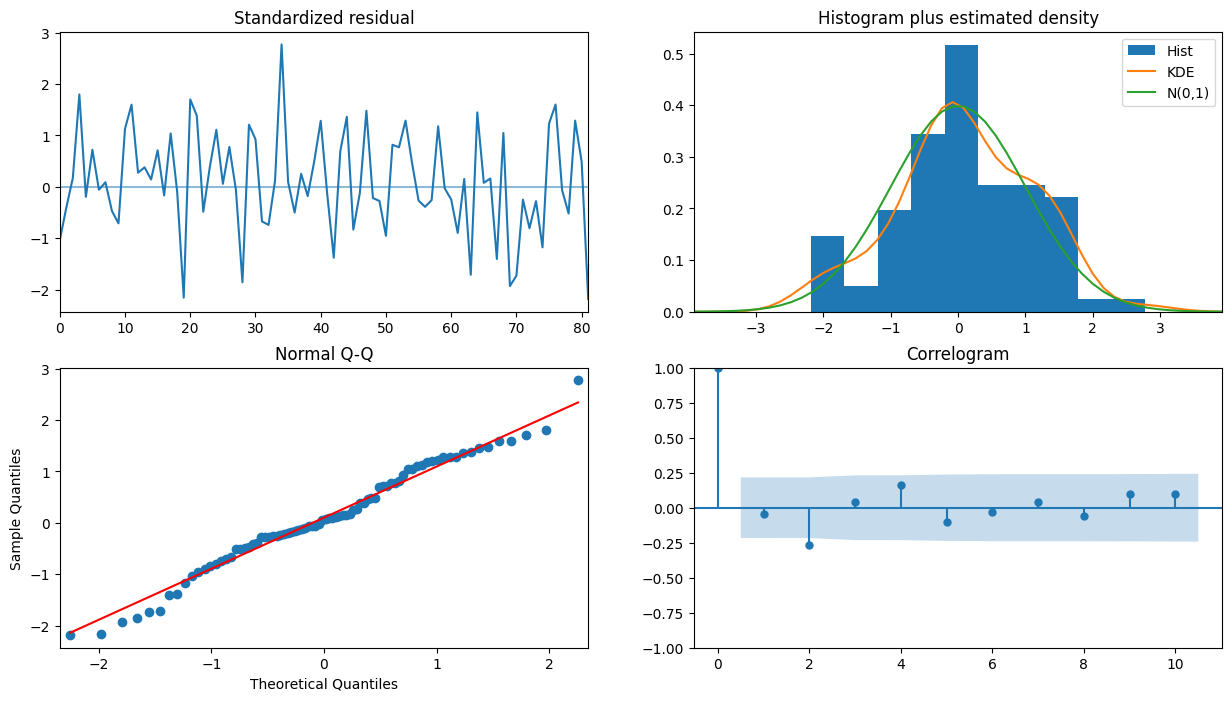

In [20]:
from matplotlib import pyplot as plt

auto_model.plot_diagnostics(figsize=(15, 8))
plt.show()


In [22]:
import numpy as np

forecast, conf_int = auto_model.predict(n_periods=10, return_conf_int=True)

# Assuming 'auto_model' is your forecasting model and 'series' is your historical data
forecast, conf_int = auto_model.predict(n_periods=10, return_conf_int=True)

# Create a range for the forecasts
forecast_index = pd.date_range(start=series.index[-1], periods=11, freq='D')[1:]

# Create the figure for plotting
fig = go.Figure()

# Add historical data to the plot
fig.add_trace(go.Scatter(x=series.index, y=series, mode='lines', name='Historical'))

# Add forecast data to the plot
fig.add_trace(go.Scatter(x=forecast_index, y=forecast, mode='lines', name='Forecast', line=dict(color='red')))

# Add confidence intervals as a filled area
fig.add_trace(go.Scatter(x=forecast_index.tolist() + forecast_index[::-1].tolist(),
                         y=np.concatenate([conf_int[:, 1], conf_int[::-1, 0]]),
                         fill='toself',
                         fillcolor='pink',
                         line=dict(color='rgba(255,255,255,0)'),
                         name='Confidence Interval',
                         showlegend=False))

# Update layout to add titles and labels
fig.update_layout(title='Forecast vs Historical Data',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  legend_title='Legend')

# Show the plot
fig.show()

c:\Users\Di heng\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Di heng\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

c:\Users\Di heng\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Di heng\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will res